In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using DSP
using ImageFiltering

# Compute CV:

used to create conv-matrix-upd-1.jld2 file. FFT based convolution is used.

In [ ]:
function cv_constructor(histogram::Histogram; α::Float64=2., n_max::Int64 = 6000)
    
    background_values = histogram.weights
    edges = histogram.edges[1]
    cv_matrix = zeros(Float64, 4096, n_max)
    
    # replace bins with 0 counts
    mask_b = iszero.(background_values)
    non_zero_min = minimum(background_values[.!mask_b])
    background_values[mask_b] .= non_zero_min
    
#     kern_background = KernelFactors.gaussian(3)
#     background_values= imfilter(background_values, kern_background)
    # ***

    # if the signal prediction == 0, then we use only background distribution
    cv_matrix[:,1] .= background_values 
    
    for i in 2:n_max
        signal_vals = cdf.(truncated(Normal(i-1, α*sqrt(i-1)), edges[1], edges[end]), edges)
        signal_vals = diff(signal_vals)
        
        # signal_vals = pdf.(Normal(i-1, α*sqrt(i-1)), h_bins)
        signal_conv = DSP.conv(signal_vals, background_values)[1:4096]
        signal_conv = abs.(signal_conv)
        
        mask = iszero.(signal_conv) # if convolution returns zero - replace it with minimum value 
        min_non_zero = minimum(signal_conv[.!mask])
        
        signal_conv[mask] .= min_non_zero
        
        if sum(signal_conv) < 0 
            signal_conv[end] += 1 - sum(signal_conv)
        elseif sum(signal_conv) > 0 
            signal_conv = signal_conv ./ sum(signal_conv)
        end
        
        cv_matrix[:,i] .= signal_conv 
    end
    
    # Apply convolution filter: 
    kern = KernelFactors.gaussian((3, 3))
    cv_matrix = imfilter(cv_matrix, kern)
    
    for i in 1:n_max
        cv_matrix[:,i] .= cv_matrix[:,i] ./ sum(cv_matrix[:,i]) 
    end
    # Coment out if not needed 
    
    return log.(cv_matrix)
end

function pixel_probability(predicted_value::Int64, observed_value::Int64, conv_matrix::Array{Float64,2})
    
    predicted_ind::Int64 = predicted_value + 1
    observed_ind::Int64 = observed_value + 1
    
    return conv_matrix[observed_ind, predicted_ind]
end

In [ ]:
#used to generate: conv-matrix-upd-1.jld

background_hist_1 = load("../data/experiment/dataset_2/m1/background.jld2")
background_hist_2 = load("../data/experiment/dataset_2/m2/background.jld2")

cv_1_1 = cv_constructor(background_hist_1["cam_1"])
cv_1_2 = cv_constructor(background_hist_1["cam_2"])
cv_1_3 = cv_constructor(background_hist_1["cam_3"])
cv_1_4 = cv_constructor(background_hist_1["cam_4"], α=5.)

cv_2_1 = cv_constructor(background_hist_2["cam_1"])
cv_2_2 = cv_constructor(background_hist_2["cam_2"])
cv_2_3 = cv_constructor(background_hist_2["cam_3"])
cv_2_4 = cv_constructor(background_hist_2["cam_4"], α=5.);

In [ ]:
# FileIO.save("../data/experiment/dataset_2/m1/conv-matrix-upd-1.jld2", 
#     Dict("cam_1" => cv_1_1, 
#         "cam_2" => cv_1_2, 
#         "cam_3" => cv_1_3, 
#         "cam_4" => cv_1_4))

# FileIO.save("../data/experiment/dataset_2/m2/conv-matrix-upd-1.jld2", 
#     Dict("cam_1" => cv_2_1, 
#         "cam_2" => cv_2_2, 
#         "cam_3" => cv_2_3, 
#         "cam_4" => cv_2_4))

# Example: 

In [ ]:
cv  = cv_2_3

fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.plot(cv[:,1], label="Background")
ax.plot(cv[:,80], label="Signal")

# ax.set_xlim(0.001, 100)
# ax.set_ylim(0.000000001, 0.05)

ax.set_yscale("log")
ax.set_xscale("log")

ax.legend(loc="upper right", ncol=1, framealpha=0.0)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

# ax.pcolormesh(log.(cv[500:1400, 3500:4000]))
ax.pcolormesh(log.(cv[1:400, 1:600]))

ax.set_xlabel("Predicted Signal")
ax.set_ylabel("Observed Signal")

# Convolution Example: 

In [ ]:
# kern = KernelFactors.gaussian((3, 3));

In [ ]:
# smeared_cv = imfilter(cv, kern);

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(5,4))

# ax.plot(smeared_cv[:,1], label="Background")
# ax.plot(smeared_cv[:,3060], label="Signal")

# # ax.set_xlim(0.001, 100)
# # ax.set_ylim(0.0000001, 0.05)

# ax.set_yscale("log")
# ax.set_xscale("log")

# ax.legend(loc="upper right", ncol=1, framealpha=0.0)

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(5,4))

# ax.pcolormesh(log.(smeared_cv[500:1400, 3500:4000]))

# ax.set_xlabel("Predicted Signal")
# ax.set_ylabel("Observed Signal")

## Convolution 2 (revised coefficients): 

used to create conv-matrix-upd-2.jld2 file. Non FFT based convolution is used, diffrent kernel and 1st column. 

In [2]:
function smooth_hist(hst)
    edg = hst.edges[1]
    vls = hst.weights
    krn = KernelFactors.gaussian(6)
    vls_1 = deepcopy(vls)
    vls_1[50:end] .= imfilter(vls[50:end], krn)
    non_zero_min = unique(sort(vls_1))[2]
    vls_1 = replace(x-> iszero(x) ? non_zero_min : x, vls_1)
    vls_1 = vls_1 ./ sum(vls_1)
    return Histogram(edg, vls_1)
end

function direct_conv(a::Array{T}, b::Array{T}) where {T <: AbstractFloat}
    m = length(a)
    n = length(b)
    c = zeros(T,m+n-1)
    @inbounds @simd for j=1:m
        @inbounds @simd for k=1:n
            c[j+k-1] += a[j]*b[k]
        end
    end
    return c
end

direct_conv (generic function with 1 method)

In [3]:
function cv_constructor(histogram::Histogram, α; n_max::Int64 = 5000, conv = true, cr_size=2)
    
    background_values = histogram.weights
    edges = histogram.edges[1]
    cv_matrix = zeros(Float64, 4096, n_max)    

#     cv_matrix[:,1] .= background_values 
    
    for i in 1:n_max
#         signal_vals = cdf.(truncated(Normal(i-1, 1 + α*sqrt(i-1)), edges[1], edges[end]), edges)
        signal_vals = cdf.(Normal(i-1, 1 + α*sqrt(i-1)), edges)
        signal_vals = diff(signal_vals)
        signal_conv = direct_conv(signal_vals, background_values)[1:4096]
        cv_matrix[:,i] .= signal_conv 
    end
    
    
    # Apply gaussian flter to the whole matrix: 
#     if conv
#         kern = KernelFactors.gaussian(cr_size) # shoulb be used > 1  
#         cv_matrix = imfilter(cv_matrix, kern)
#     end
    
    # Apply gaussian flter along one dimension
    if conv
        for i in 1:4096
            krn = KernelFactors.gaussian(cr_size)
            cv_matrix[i,:] .= imfilter(cv_matrix[i,:], krn) 
        end
    end
    
    for i in 1:n_max
        cv_matrix[:,i] .= cv_matrix[:,i] ./ sum(cv_matrix[:,i]) 
    end
    
    return log.(cv_matrix)
#     return cv_matrix
end

cv_constructor (generic function with 1 method)

In [4]:
background_hist_1 = load("../data/experiment/dataset_2/m1/background.jld2")

smoth_hist = (
    cam_1 = smooth_hist(background_hist_1["cam_1"]),
    cam_2 = smooth_hist(background_hist_1["cam_2"]),
    cam_3 = smooth_hist(background_hist_1["cam_3"]),
    cam_4 = smooth_hist(background_hist_1["cam_4"]), 
);

cv_1_1 = cv_constructor(smoth_hist.cam_1, 2.0)
cv_1_2 = cv_constructor(smoth_hist.cam_2, 2.0)
cv_1_3 = cv_constructor(smoth_hist.cam_3, 2.0)
cv_1_4 = cv_constructor(smoth_hist.cam_4, 2.0);

In [5]:
background_hist_2 = load("../data/experiment/dataset_2/m2/background.jld2")

smoth_hist = (
    cam_1 = smooth_hist(background_hist_2["cam_1"]),
    cam_2 = smooth_hist(background_hist_2["cam_2"]),
    cam_3 = smooth_hist(background_hist_2["cam_3"]),
    cam_4 = smooth_hist(background_hist_2["cam_4"]), 
);

cv_2_1 = cv_constructor(smoth_hist.cam_1, 2.0)
cv_2_2 = cv_constructor(smoth_hist.cam_2, 2.0)
cv_2_3 = cv_constructor(smoth_hist.cam_3, 2.0)
cv_2_4 = cv_constructor(smoth_hist.cam_4, 2.0);


In [24]:
# FileIO.save("../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2", 
#     Dict("cam_1" => cv_1_1, 
#         "cam_2" => cv_1_2, 
#         "cam_3" => cv_1_3, 
#         "cam_4" => cv_1_4))

# FileIO.save("../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2", 
#     Dict("cam_1" => cv_2_1, 
#         "cam_2" => cv_2_2, 
#         "cam_3" => cv_2_3, 
#         "cam_4" => cv_2_4))

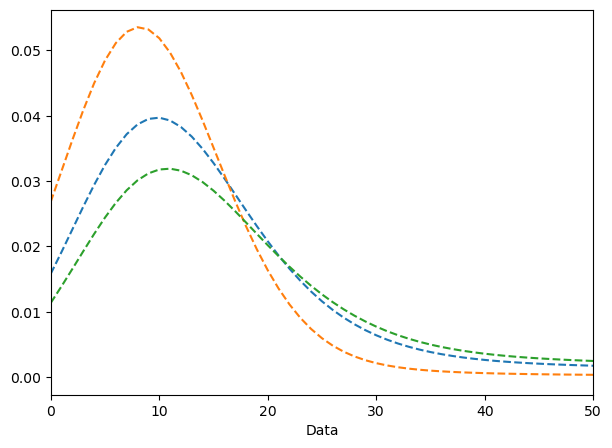

PyObject Text(0.5, 24.0, 'Data')

In [6]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(exp.(cv_2_1[:,10]), "--", color="C0")
ax.plot(exp.(cv_2_2[:,10]), "--", color="C1")
ax.plot(exp.(cv_2_3[:,10]), "--", color="C2")

# ax.set_yscale("log")

ax.set_xlim(0,50)
ax.set_xlabel("Data")
# ax.set_ylim(0,0.08)

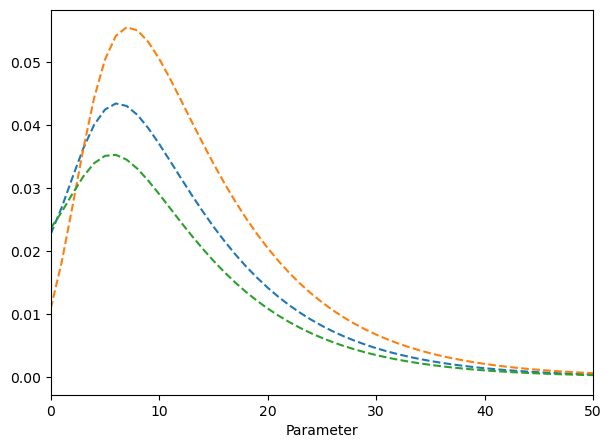

PyObject Text(0.5, 24.0, 'Parameter')

In [7]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(exp.(cv_2_1[10,:]), "--", color="C0")
ax.plot(exp.(cv_2_2[10,:]), "--", color="C1")
ax.plot(exp.(cv_2_3[10,:]), "--", color="C2")

# ax.set_yscale("log")

ax.set_xlim(0,50)

ax.set_xlabel("Parameter")

# ax.set_ylim(-1,0)

# Comparison: 

In [8]:
dem_nm = cv_constructor(smoth_hist.cam_1, 2.0, conv = false);

In [9]:
dem_mod = cv_constructor(smoth_hist.cam_1, 2.0, conv = true, cr_size=2);

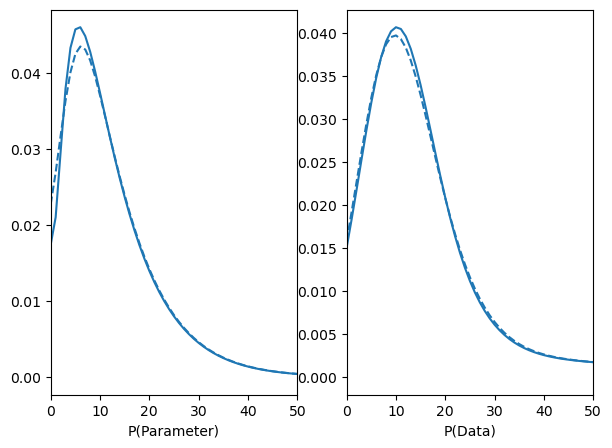

PyObject Text(0.5, 24.0, 'P(Data)')

In [23]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,5))

ind = 10

ax2.plot(exp.(dem_nm[:,ind]), "-", color="C0")
ax2.plot(exp.(dem_mod[:,ind]), "--", color="C0")

ax.plot(exp.(dem_nm[ind,:]), "-", color="C0")
ax.plot(exp.(dem_mod[ind,:]), "--", color="C0")

ax.set_xlim(0,50)
ax.set_xlabel("P(Parameter)")

ax2.set_xlim(0,50)
ax2.set_xlabel("P(Data)")